# NLP wiht LSTM TensorFlow Youtube Tutorial 

Video: https://www.youtube.com/watch?v=ZMudJXhsUpY&list=PLQY2H8rRoyvzDbLUZkbudP-MFQZwNmU4S&index=6

Code: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/Course%203%20-%20Week%204%20-%20Lesson%202%20-%20Notebook.ipynb#scrollTo=w9vH8Y59ajYL

## Setup 

In [1]:
! pip install matplotlib

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np 

import os

2024-10-13 19:11:14.634350: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-13 19:11:15.121046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 19:11:15.315585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 19:11:15.383544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 19:11:15.860053: I tensorflow/core/platform/cpu_feature_guar

## Data

In [3]:
# Datensatz laden
path_to_file = os.path.abspath("../exaple_text.txt")
data = open(path_to_file, 'rb').read().decode(encoding='utf-8')

print(f"Inhalte des Datensatzes: \n\n{data[:250]}")

Inhalte des Datensatzes: 

Wie geht es dir?
Mir geht's gut, danke.
Was machst du heute?
Hast du gut geschlafen?
Wo wohnst du?
Ich wohne in Berlin.
Wie spät ist es?
Es ist schon ziemlich spät.
Hast du heute Zeit?
Was hast du am Wochenende vor?
Kannst du mir bitte helfen?
Was ha


In [4]:
# Corpus erstellen
tokenizer = Tokenizer()
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(f"Der Tokenizer kennt {total_words} Wörter")
print(f"Die Wörter werden folgenden Indexe zugenortnet: {tokenizer.word_index}")


Der Tokenizer kennt 199 Wörter
Die Wörter werden folgenden Indexe zugenortnet: {'du': 1, 'ich': 2, 'das': 3, 'hast': 4, 'habe': 5, 'was': 6, 'wie': 7, 'es': 8, 'ist': 9, 'heute': 10, 'schon': 11, 'kannst': 12, 'möchtest': 13, 'hier': 14, 'wann': 15, 'nicht': 16, 'lange': 17, 'kann': 18, 'wo': 19, 'in': 20, 'zeit': 21, 'zu': 22, 'noch': 23, 'zum': 24, 'der': 25, 'bin': 26, 'dir': 27, 'mir': 28, 'gut': 29, 'bitte': 30, 'etwas': 31, 'gehen': 32, 'muss': 33, 'war': 34, 'machst': 35, 'spät': 36, 'ziemlich': 37, 'wochenende': 38, 'frei': 39, 'wir': 40, 'uns': 41, 'mich': 42, 'schön': 43, 'den': 44, 'film': 45, 'viel': 46, 'tun': 47, 'mit': 48, 'keine': 49, 'einen': 50, 'dauert': 51, 'finde': 52, 'die': 53, 'nächste': 54, 'gibt': 55, 'komme': 56, 'bleibst': 57, 'gleich': 58, 'an': 59, 'meinen': 60, 'vergessen': 61, 'dein': 62, 'morgen': 63, 'bus': 64, 'weit': 65, 'bis': 66, 'eine': 67, 'geht': 68, "geht's": 69, 'danke': 70, 'geschlafen': 71, 'wohnst': 72, 'wohne': 73, 'berlin': 74, 'am': 75, 

In [5]:
input_sequences = []

# Wandelt jede Zeile in eine Liste von Wortindizes 
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	# n-Gramm-Sequenz generieren
	for i in range(1, len(token_list)):

		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# Alle Sequences auf gleiche Laenge bringen 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Aufteilen in Prädiktoren und Labels
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

## Modell

In [6]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)
#print model.summary()
print(model)


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.0644 - loss: 5.4155
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0961 - loss: 4.8823
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1340 - loss: 4.3788
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1814 - loss: 3.8029
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2640 - loss: 3.1062
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3913 - loss: 2.4368
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4648 - loss: 2.0137
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5382 - loss: 1.5279
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6465 - loss: 1.2569
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6713 - loss: 1.0341
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6922 - loss: 0.9363
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/ste

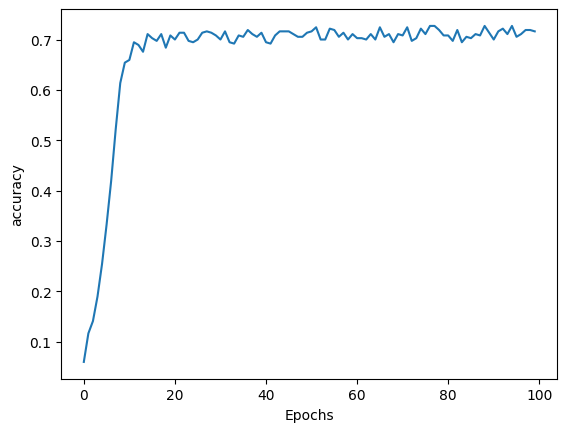

In [7]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

## Ausführen 

In [8]:
seed_text = "Hallo ich bin "
next_words = 10
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Hallo ich bin  gleich fertig fertig fertig station station gerne station nächste gerne


## Warscheinlichkeiten 

In [14]:
import numpy as np

seed_text = "Oma hat"
top_k = 10  # Anzahl der Top-Wörter

# Tokenisierung und Padding des Eingabetexts
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

# Vorhersagen berechnen
predictions = model.predict(token_list, verbose=0)[0]  # Softmax-Ausgabe

# Top-10 wahrscheinlichste Wörter finden
top_indices = np.argsort(predictions)[-top_k:][::-1]  #Sortiere absteigend

# Wörter und Wahrscheinlichkeiten sammeln
top_words = [(word, predictions[index]) for word, index in tokenizer.word_index.items() if index in top_indices]

# Sortiere die Wörter nach Wahrscheinlichkeit in absteigender Reihenfolge
top_words = sorted(top_words, key=lambda x: x[1], reverse=True)

# Ausgabe der Top-10 Wörter und Wahrscheinlichkeiten
print(f"Top {top_k} nächste Wörter für '{seed_text}':")
for word, prob in top_words:
    print(f"{word}: {(prob * 100):.4f} %")


Top 10 nächste Wörter für 'Oma hat':
du: 31.6255 %
hast: 2.3181 %
ist: 2.2994 %
arbeiten: 1.9791 %
war: 1.9179 %
möchtest: 1.7864 %
finde: 1.7796 %
komme: 1.6677 %
geht's: 1.5688 %
wohnst: 1.5462 %
